<a href="https://colab.research.google.com/github/JatinMoolchandani2002/StyleGAN/blob/main/SketchGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

#  STYLEGAN COMPONENTS:
### 1. ProGAN
### 2. z-Mapping (to unentagle the latent space z into w)
### 3. AdaIN
### 4. Upsampling + Convolution with factors
### 5. (Styling + Stochastic) Variation
### 6. Truncation Trick

In [ ]:
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
!pip install --upgrade --no-cache-dir gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
celeb_dataset_url = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL"
gdown.download(celeb_dataset_url, 'celeba_hq.zip', quiet=False)
!unzip celeba_hq.zip -d ./celeba_hq

Downloading...
From: https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL
To: /content/celeba_hq.zip
100%|██████████| 2.74G/2.74G [00:57<00:00, 47.3MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: ./celeba_hq/train/male/188205.jpg  
  inflating: ./celeba_hq/train/male/110130.jpg  
  inflating: ./celeba_hq/train/male/137490.jpg  
  inflating: ./celeba_hq/train/male/057413.jpg  
  inflating: ./celeba_hq/train/male/097064.jpg  
  inflating: ./celeba_hq/train/male/118327.jpg  
  inflating: ./celeba_hq/train/male/017072.jpg  
  inflating: ./celeba_hq/train/male/147334.jpg  
  inflating: ./celeba_hq/train/male/062749.jpg  
  inflating: ./celeba_hq/train/male/028764.jpg  
  inflating: ./celeba_hq/train/male/169870.jpg  
  inflating: ./celeba_hq/train/male/155103.jpg  
  inflating: ./celeba_hq/train/male/188011.jpg  
  inflating: ./celeba_hq/train/male/121728.jpg  
  inflating: ./celeba_hq/train/male/132090.jpg  
  inflating: ./celeba_hq/train/male/043505.jpg  
  inflating: ./celeba_hq/train/male/096015.jpg  
  inflating: ./celeba_hq/train/male/195083.jpg  
  inflating: ./celeba_hq/train/male/062399.jpg  
  inflating: ./cel

In [ ]:
# batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
batch_sizes = {2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 2, 10: 1}
train_step_ratio = {k: batch_sizes[2]/v for k,v in batch_sizes.items()}
print(train_step_ratio)


ds_train = tf.keras.preprocessing.image_dataset_from_directory('celeba_hq', label_mode=None, image_size = (64,64), batch_size=32).map(lambda x:x/255.0)


{2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 2.0, 10: 4.0}
Found 30000 files belonging to 1 classes.


# Helper Functions

In [ ]:
def resize_image(image_new_dim, image):
  image = tf.image.resize(image, size=(image_new_dim, image_new_dim), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.cast(image, tf.float32) / 127.5 - 1.0
  return image

def data_loader(image_dim):
  batch_size = batch_sizes[int(np.log2(image_dim))]

  dl = ds_train.map(partial(resize_image, image_dim), num_parallel_calls=tf.data.AUTOTUNE).unbatch()
  dl = dl.shuffle(200).batch(batch_size, drop_remainder=True).prefetch(1).repeat()
  return dl

In [ ]:
def PixelNorm(x, epsilon = 1e-8):
  return x / tf.math.sqrt(tf.reduce_mean(x**2, axis = -1, keepdims=True) + epsilon)

In [ ]:
def fade_in(a, b, alpha):
  return (1-alpha) * a + alpha * b

In [ ]:
def WLoss(y_true, y_pred):
  return -tf.reduce_mean(y_true * y_pred)

In [ ]:
def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c])
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False)
    group_std = tf.sqrt(group_var + epsilon)
    avg_std = tf.reduce_mean(group_std, axis=[1, 2, 3], keepdims=True)
    x = tf.tile(avg_std, [group_size, h, w, 1])
    return tf.concat([input_tensor, x], axis=-1)

# Custom Dense Layer

In [ ]:
class CustomDense(tf.keras.layers.Layer):
  def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
    super(CustomDense, self).__init__(**kwargs)
    self.units = units
    self.gain = gain
    self.learning_rate_multiplier = learning_rate_multiplier

  def build(self, input_shape):
    self.in_channels = input_shape[-1]
    self.initializer = tf.keras.initializers.RandomNormal(
        mean = 0.0, stddev = 1.0/self.learning_rate_multiplier
    )
    self.w = self.add_weight(
        shape = [self.in_channels, self.units],
        initializer = self.initializer,
        trainable = True,
        name = 'kernel'
    )

    self.b = self.add_weight(
        shape = (self.units, ),
        initializer = "zeros",
        trainable = True,
        name = 'bias'
    )

    self.scale = tf.sqrt(self.gain / self.in_channels)

  def call(self, inputs):
    output = tf.add(tf.matmul(inputs, self.scale * self.w), self.b)
    return output * self.learning_rate_multiplier

# Custom Conv2D layer

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
  def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
    super(CustomConv2D, self).__init__(**kwargs)
    self.out_channels = out_channels
    self.gain = gain
    self.kernel = kernel
    self.pad = kernel !=1

  def build(self, input_shape):
    self.in_channels = input_shape[-1]
    self.initializer = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
    self.w = self.add_weight(
        shape=[self.kernel, self.kernel, self.in_channels, self.out_channels],
        initializer = self.initializer,
        trainable = True,
        name = 'kernel'
    )

    self.b = self.add_weight(
        shape=(self.out_channels, ),
        initializer = 'zeros',
        trainable = True,
        name = 'bias'
    )

    self.scale = tf.sqrt(self.gain / (self.kernel * self.kernel * self.in_channels))

  def call(self, inputs):
    if(self.pad):
      x = tf.pad(inputs, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT')
    else:
      x = inputs
    output = (tf.nn.conv2d(x, filters=self.scale * self.w, strides=1, padding='VALID') + self.b)
    return output

# Mapping Network z -> w

In [ ]:
def MappingNetwork(num_stages, z_dim):

  z = tf.keras.Input(shape=(z_dim))
  w = PixelNorm(z)
  for i in range(8):
    w = CustomDense(512, learning_rate_multiplier = 0.01)(w)
    w = tf.keras.layers.LeakyReLU(0.2)(w)

  w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
  return tf.keras.Model(z, w, name='MappingNetwork')

In [ ]:
mappingModel = MappingNetwork(2, 512)
mappingModel.summary()

Model: "MappingNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf.math.pow (TFOpLambda)       (None, 512)          0           ['input_1[0][0]']                
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None, 1)           0           ['tf.math.pow[0][0]']            
 a)                                                                                               
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 1)           0           ['tf.math.reduce_mea

# Adaptive Instance Normalization

In [ ]:
class AdaIN(tf.keras.layers.Layer):
  def __init__(self, gain=1, **kwargs):
    super(AdaIN, self).__init__(*kwargs)
    self.gain = gain

  def build(self, input_shapes):
    x_shape = input_shapes[0]
    w_shape = input_shapes[1]

    self.x_channels = x_shape[-1]
    self.w_channels = w_shape[-1]

    self.scale_factor = CustomDense(self.x_channels, gain=1)
    self.bias_factor = CustomDense(self.x_channels, gain=1)

  def call(self, inputs):
    x, w = inputs
    sf = tf.reshape(self.scale_factor(w), [-1, 1, 1, self.x_channels])
    bf = tf.reshape(self.bias_factor(w), [-1, 1, 1, self.x_channels])

    return sf * x + bf

# Add Stochastic Variation through noise

In [ ]:
class AddNoise(tf.keras.layers.Layer):
  def build(self, input_shapes):
    n, h, w, c = input_shapes[0]
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
    self.wghts = self.add_weight(
        shape=[1,1,1,c],
        initializer = self.initializer,
        trainable = True,
        name = 'kernel'
    )

  def call(self, inputs):
    x, noise = inputs
    return self.wghts * noise + x

# Generator Model

In [ ]:
class Generator:
  def __init__(self, start_resolution_in_log2, target_resolution_in_log2):
    self.start_res_log2 = start_resolution_in_log2
    self.target_res_log2 = target_resolution_in_log2
    self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

    self.gen_blocks = []
    self.toRGB = []
    self.noise_inputs = []

    self.filters_num = {
        0:512,
        1:512,
        2:512,
        3:512,
        4:512,
        5:512,
        6:256,
        7:128,
        8:64,
        9:32,
        10:16
    }

    self.start_resolution = 2 ** self.start_res_log2

    self.input_shape = [self.start_resolution, self.start_resolution, self.filters_num[self.start_res_log2]]
    self.gen_input = tf.keras.Input(shape=self.input_shape, name='generator_input')

    for i in range(self.start_res_log2, self.target_res_log2 + 1):
      filter_num = self.filters_num[i]
      resolution = 2**i
      self.noise_inputs.append(
          tf.keras.Input(shape=(resolution, resolution, 1), name=f"noise_{resolution}X{resolution}")
      )

      to_RGB = tf.keras.Sequential([
          tf.keras.Input(shape = (resolution, resolution, filter_num)),
          CustomConv2D(out_channels=3, kernel=1, gain = 1)
      ], name=f"to_rgb_{resolution}X{resolution}")
      self.toRGB.append(to_RGB)

      is_base = i == self.start_res_log2
      if is_base:
        input_shape = (resolution , resolution, self.filters_num[i-1])
      else:
        input_shape = (2**(i-1), 2**(i-1), self.filters_num[i-1])
      g_block = self.build_block(
          filter_num, resolution=resolution, input_shape = input_shape, is_base = is_base
      )
      self.gen_blocks.append(g_block)

  def build_block(self, filter, resolution, input_shape, is_base):
    input_to_the_block = tf.keras.Input(shape = input_shape, name=f'input_to_block_gen_res_{resolution}X{resolution}')
    noise = tf.keras.Input(shape = (resolution, resolution, 1), name = f'noise_to_gen_res_{resolution}X{resolution}')
    w = tf.keras.Input(shape = 512)
    x = input_to_the_block

    if not is_base:
      x = tf.keras.layers.UpSampling2D((2,2))(x)
      x = CustomConv2D(out_channels=filter, kernel=3, gain=2)(x)
    x = AddNoise()([x, noise])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = AdaIN()([x, w])

    x = CustomConv2D(out_channels=filter, kernel=3, gain=2)(x)
    x = AddNoise()([x, noise])
    x  = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = AdaIN()([x, w])

    return tf.keras.Model([input_to_the_block, noise, w], x, name = f"gen_block_res_{resolution}X{resolution}")

  def grow(self, resolution_log2):
    resolution = 2 ** resolution_log2
    num_stages = resolution_log2 - self.start_res_log2 + 1
    w = tf.keras.Input(shape=(self.num_stages, 512), name='w')

    alpha = tf.keras.Input(shape = (1), name='alpha')
    x = self.gen_blocks[0]([self.gen_input, self.noise_inputs[0], w[:,0]])

    if(num_stages == 1): #base block
      rgb = self.toRGB[0](x)
    else:   #any block after base block
      for i in range(1, num_stages - 1):
        x = self.gen_blocks[i]([x, self.noise_inputs[i],  w[:, i]])

      old_rgb = self.toRGB[num_stages - 2](x)
      old_rgb = tf.keras.layers.UpSampling2D((2,2))(old_rgb)

      i = num_stages - 1

      x = self.gen_blocks[i]([x, self.noise_inputs[i], w[:, i]])

      new_rgb = self.toRGB[i](x)
      rgb = fade_in(new_rgb, old_rgb, alpha[0])

    return tf.keras.Model(
        [self.gen_input, w, self.noise_inputs, alpha],
        rgb,
        name = f'generator_{resolution}X{resolution}'
    )

  def test(self):
    return self.gen_blocks, self.toRGB

# Descriminator Model

In [ ]:
class Descriminator:
  def __init__(self, start_resolution_in_log2, target_resolution_in_log2):
    self.start_res_log2 = start_resolution_in_log2
    self.target_res_log2 = target_resolution_in_log2
    self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

    self.filters_num = {
        0:512,
        1:512,
        2:512,
        3:512,
        4:512,
        5:512,
        6:256,
        7:128,
        8:64,
        9:32,
        10:16
    }

    self.disc_blocks = []
    self.fromRGB = []

    for i in range(self.start_res_log2, self.target_res_log2 + 1):
      resolution = 2**i
      filter_num = self.filters_num[i]

      fromRGB = tf.keras.Sequential([
          tf.keras.Input(shape = (resolution, resolution, 3), name = f"from_rgb_input_{resolution}X{resolution}"),
          CustomConv2D(filter_num, kernel=1, gain=2),
          tf.keras.layers.LeakyReLU(0.2)
      ], name=f"from_rgb_{resolution}X{resolution}")

      self.fromRGB.append(fromRGB)

      input_shape = [resolution, resolution, filter_num]

      if len(self.disc_blocks) == 0:
        self.disc_blocks.append(
            self.build_base(filter_num, resolution)
        )
      else:
        self.disc_blocks.append(
            self.build_block(filter_num, self.filters_num[i-1], resolution)
        )

  def build_base(self, filter_num, resolution):
    input_tensor = tf.keras.Input(shape=(resolution, resolution, filter_num), name = f"disc_res_{resolution}X{resolution}")
    x = minibatch_std(input_tensor)
    x = input_tensor
    x = CustomConv2D(filter_num, kernel=3, gain=2)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = CustomDense(filter_num)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = CustomDense(1)(x)
    return tf.keras.Model(input_tensor, x, name = f'disc_base_res{resolution}X{resolution}')

  def build_block(self, filter_num_1, filter_num_2, resolution):
    input_tensor = tf.keras.Input(shape=(resolution, resolution, filter_num_1), name = f"disc_res_{resolution}X{resolution}")
    x = minibatch_std(input_tensor)
    x = input_tensor
    x = CustomConv2D(filter_num_1, kernel=3, gain=2)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = CustomConv2D(filter_num_2, kernel=3, gain=2)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.AveragePooling2D()(x)

    return tf.keras.Model(input_tensor, x, name=f"disc_block_res_{resolution}X{resolution}")

  def grow(self, resolution_log2):
    resolution = 2 ** resolution_log2
    num_stages = resolution_log2 - self.start_res_log2
    input_image = tf.keras.Input(shape=(resolution, resolution, 3), name = f"disc_image_input_res_{resolution}X{resolution}")

    alpha = tf.keras.Input(shape = (1), name='alpha')

    x = self.fromRGB[num_stages](input_image)
    x = self.disc_blocks[num_stages](x)

    if(num_stages > 0):
      num_stages -= 1
      downsampled_image = tf.keras.layers.AveragePooling2D((2,2))(input_image)
      y = self.fromRGB[num_stages](downsampled_image)
      x = fade_in(x, y, alpha[0])

      for i in range(num_stages, -1, -1):
        x = self.disc_blocks[i](x)
    return tf.keras.Model([input_image, alpha], x, name = f"disc_res_{resolution}X{resolution}")

  def test(self):
    return self.disc_blocks, self.fromRGB

In [ ]:

gen = Generator(2, 4)

# gen.grow(4)
g_blocks, rgb_blocks = gen.test()



Model: "gen_block_res_8X8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_to_block_gen_res_8X8 (In  [(None, 4, 4, 512)]  0          []                               
 putLayer)                                                                                        
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 8, 8, 512)    0           ['input_to_block_gen_res_8X8[0][0
                                                                 ]']                              
                                                                                                  
 custom_conv2d_3 (CustomConv2D)  (None, 8, 8, 512)   2359808     ['up_sampling2d[0][0]']          
                                                                                  

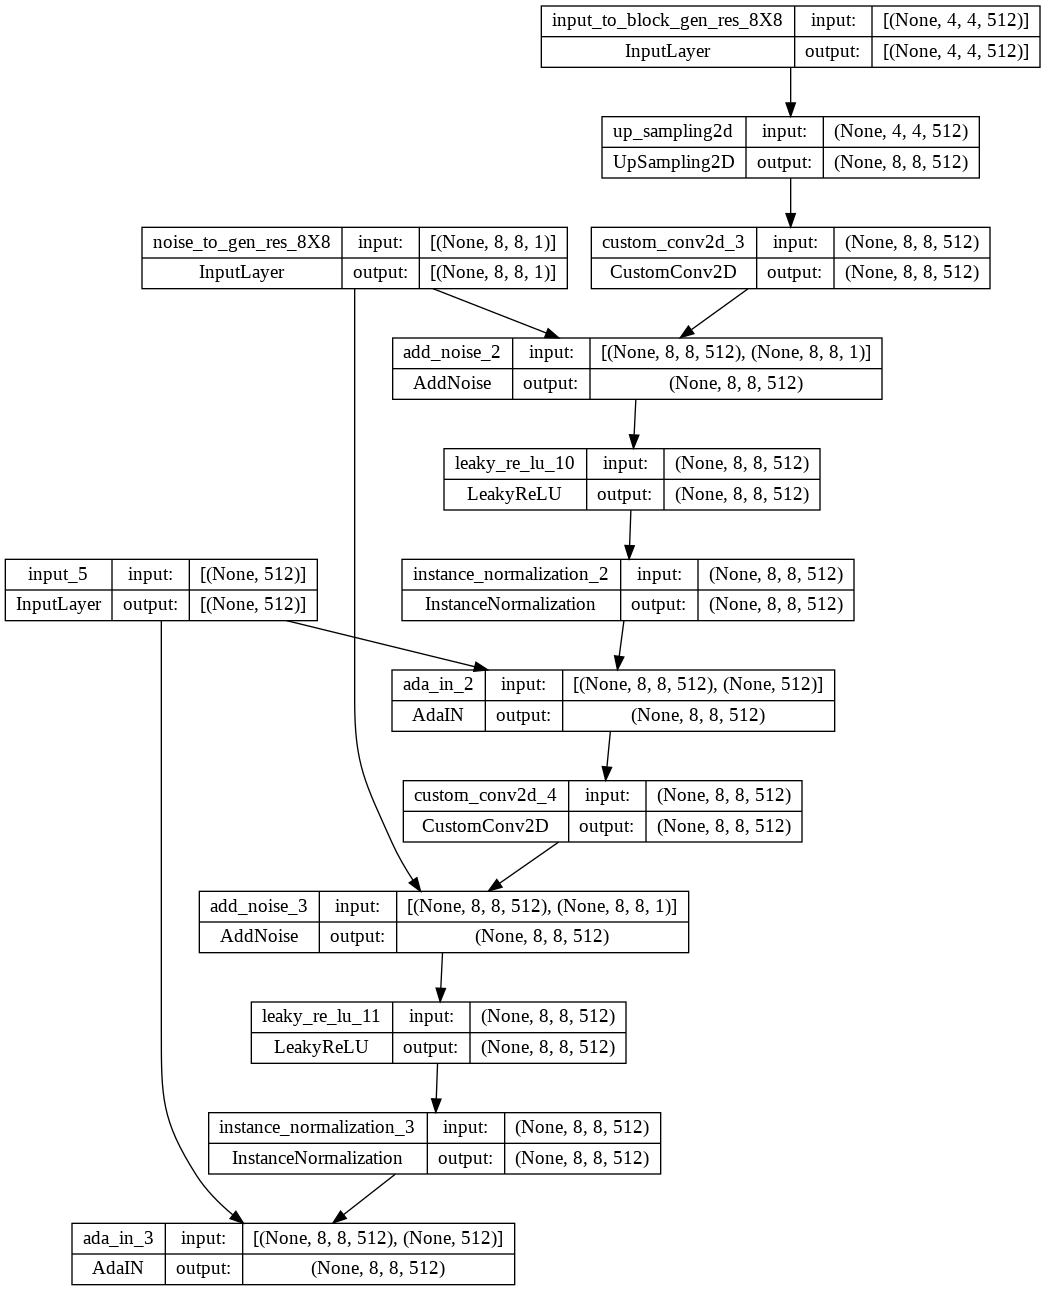

In [ ]:
g_blocks[1].summary()
tf.keras.utils.plot_model(g_blocks[1], show_shapes = True)

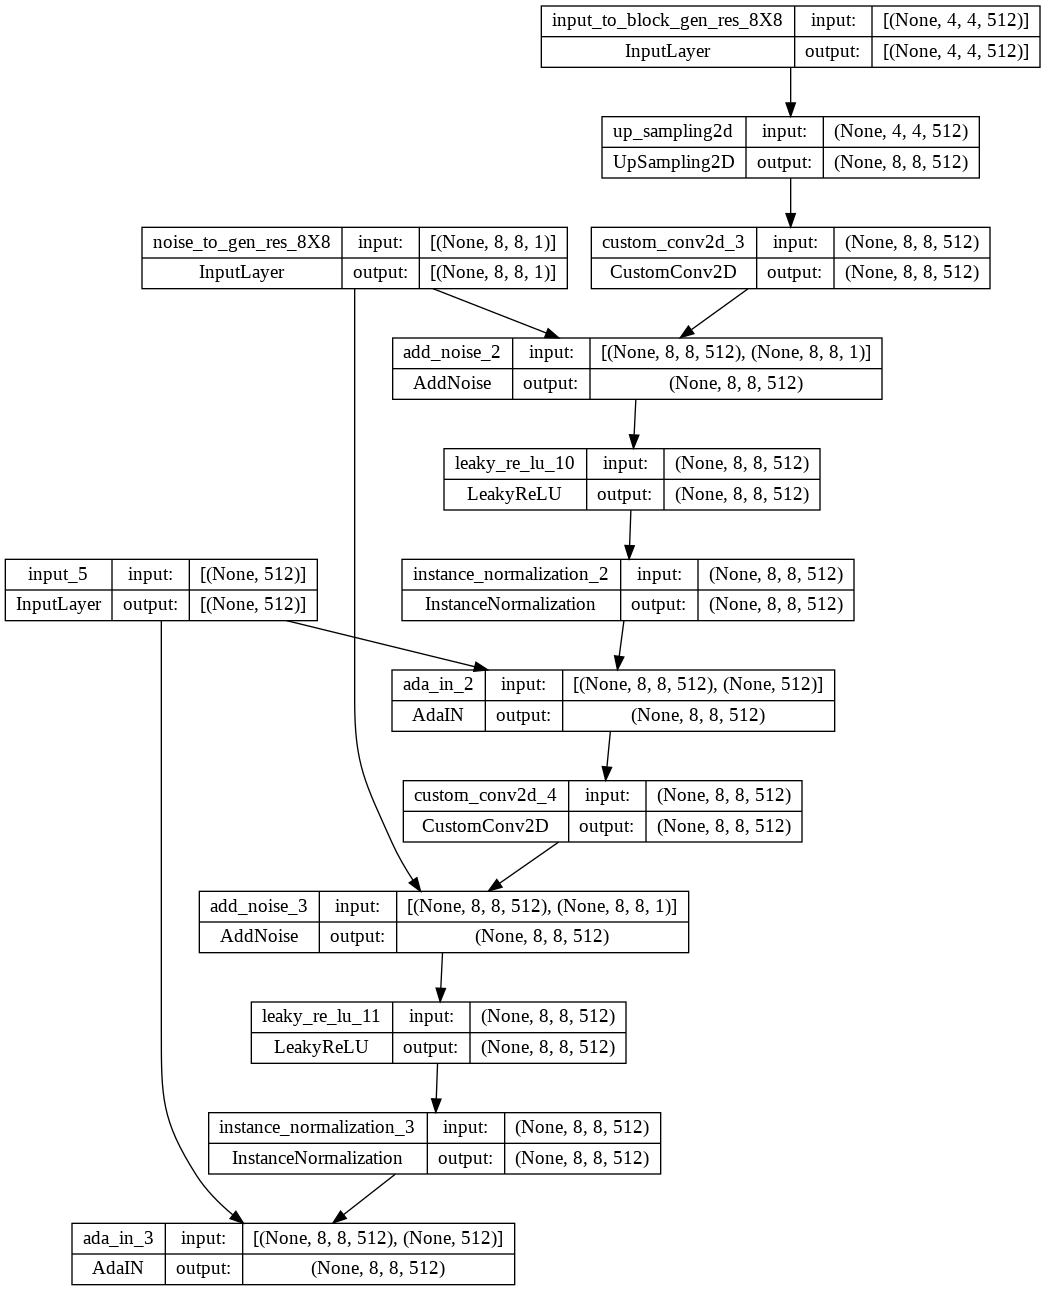

In [ ]:
tf.keras.utils.plot_model(g_blocks[1], show_shapes = True)

In [ ]:
disc = Descriminator(2, 4)
disc_blocks, fromRGB_blocks = disc.test()

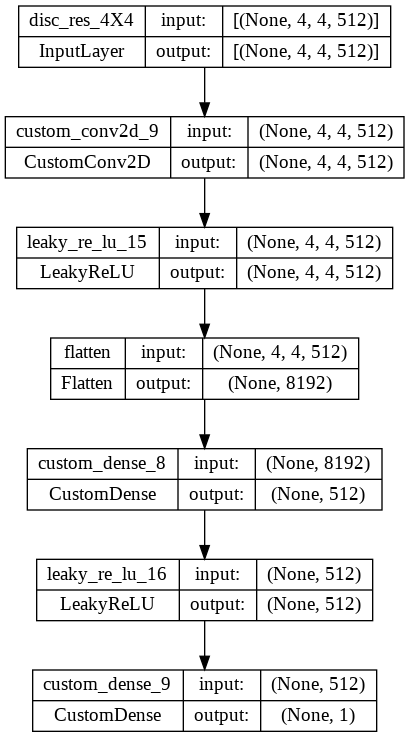

In [ ]:
tf.keras.utils.plot_model(disc_blocks[0], show_shapes = True)

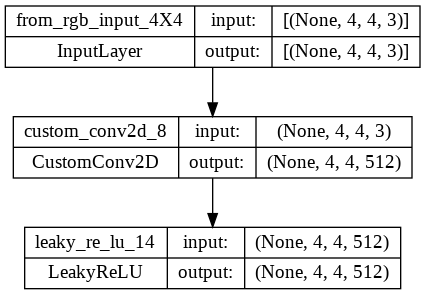

In [ ]:
tf.keras.utils.plot_model(fromRGB_blocks[0], show_shapes = True)

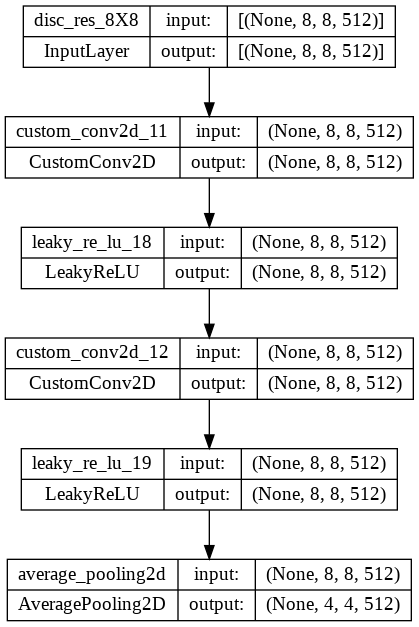

In [ ]:
tf.keras.utils.plot_model(disc_blocks[1], show_shapes = True)

# Building StyleGAN with custom training loops

In [ ]:
class styleGAN(tf.keras.Model):
  def __init__(self, z_dim=512, start_res=4, target_res=64, **kwargs):
    super(styleGAN, self).__init__(**kwargs)
    self.z_dim = z_dim
    self.start_res_log2 = int(np.log2(start_res))
    self.target_res_log2 = int(np.log2(target_res))
    self.current_res_log2 = self.target_res_log2
    self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

    self.alpha = tf.Variable(1.0, dtype='float32', trainable=False, name='alpha')

    self.mappingModel = MappingNetwork(self.num_stages, self.z_dim)
    self.disc_builder = Descriminator(self.start_res_log2, self.target_res_log2)
    self.gen_builder = Generator(self.start_res_log2, self.target_res_log2)
    self.gen_input = self.gen_builder.input_shape

    self.training_phase = None
    self.train_step_counter = tf.Variable(0.0, dtype='float32', trainable=False, name='train_step_counter')

    # self.loss_weights = {'gradient_penalty': 10, 'drift': 0.001}
    self.loss_weights = {'gradient_penalty': 10}

  def grow(self, resolution):
    tf.keras.backend.clear_session()
    res_log2 = int(np.log2(resolution))
    self.disc_grow = self.disc_builder.grow(res_log2)
    self.gen_grow = self.gen_builder.grow(res_log2)
    self.current_res_log2 = res_log2
    print(f"Model_Grow_res_{resolution}X{resolution}")

  def compile(self, steps_per_epoch, training_phase, resolution, disc_optim, gen_optim, *args, **kwargs):
    self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
    self.steps_per_epoch = steps_per_epoch
    self.training_phase = training_phase
    self.resolution = resolution
    self.train_step_counter.assign(0)

    if resolution != 2**self.current_res_log2:
      self.grow(resolution)
      self.disc_optim = disc_optim
      self.gen_optim = gen_optim

    self.disc_metrics = tf.keras.metrics.Mean(name='disc_metrics')
    self.gen_metrics = tf.keras.metrics.Mean(name='gen_metrics')
    super(styleGAN, self).compile(*args, **kwargs)

  @property
  def metrics(self):
    return [self.gen_metrics, self.disc_metrics]

  def generate_noise(self, batch_size):
    noise = [tf.random.normal((batch_size, 2 ** res, 2 ** res, 1))
            for res in range(self.start_res_log2, self.target_res_log2 + 1)
    ]
    return noise

  def gradient_loss(self, grad):
    loss = tf.square(grad)
    loss = tf.reduce_sum(loss, axis = tf.range(1, tf.size(tf.shape(loss))))
    loss = tf.sqrt(loss)
    loss = tf.reduce_mean(tf.square(loss - 1))
    return loss

  def train_step(self, real_images):
    self.train_step_counter.assign_add(1)

    if(self.training_phase == 'Transition'):
      self.alpha.assign(
          tf.cast(self.train_step_counter / self.steps_per_epoch, tf.float32)
      )

    elif(self.training_phase == 'Stable'):
      self.alpha.assign(1.0)

    else:
      raise NotImplementedError

    alpha = tf.expand_dims(self.alpha, axis = 0)
    batch_size = tf.shape(real_images)[0]
    real_labels = tf.ones(batch_size)
    fake_labels = -tf.ones(batch_size)

    constant_input = tf.ones((tuple([batch_size] + list(self.gen_input))))        #(batch_size x 4 x 4 x 512) in our case
    z = tf.random.normal(shape = (batch_size, self.z_dim))                      #(batch_size x 512)
    noise = self.generate_noise(batch_size)

    with tf.GradientTape() as gen_tape:
      w = self.mappingModel(z)
      fake_images = self.gen_grow([constant_input, w, noise, alpha])
      disc_pred_for_fake = self.disc_grow([fake_images, alpha])

      gen_loss = WLoss(real_labels, disc_pred_for_fake)

      trainable_weights = (
          self.mappingModel.trainable_weights + self.gen_grow.trainable_weights
      )

      grads = gen_tape.gradient(gen_loss, trainable_weights)
      self.gen_optim.apply_gradients(
          zip(grads, trainable_weights)
      )

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gradient_tape:
      disc_pred_for_fake = self.disc_grow([fake_images, alpha])
      disc_pred_for_real = self.disc_grow([real_images, alpha])

      disc_loss_for_fake_pred = WLoss(fake_labels, disc_pred_for_fake)
      disc_loss_for_real_pred = WLoss(real_labels, disc_pred_for_real)

      epsilon = tf.random.uniform(shape = (batch_size, 1, 1, 1))
      interpolations = epsilon * real_images + (1 - epsilon) * fake_images
      disc_pred_for_fake_grads = self.disc_grow([interpolations, alpha])
      gradient_tape.watch(interpolations)

      gradients_fake = gradient_tape.gradient(disc_pred_for_fake_grads, [interpolations])

      gradient_penalty = self.loss_weights["gradient_penalty"] * self.gradient_loss(gradients_fake)

      disc_loss = disc_pred_for_fake + disc_pred_for_real + gradient_penalty

      disc_grads = disc_tape.gradient(disc_loss, self.disc_grow.trainable_weights)
      self.disc_optim.apply_gradients(
          zip(disc_grads, self.disc_grow.trainable_weights)
      )

      self.disc_metrics.update_state(disc_loss)
      self.gen_metrics.update_state(gen_loss)

      return {
          'gen_loss': self.gen_metrics.result(),
          'disc_loss': self.disc_metrics.result()
      }


  def call(self, inputs:dict()):
    w = inputs.get('style_code', None)
    z = inputs.get('z', None)
    batch_size = inputs.get('batch_size', 1)
    noise = inputs.get('noise', None)
    alpha = tf.expand_dims(inputs.get('alpha', None), axis = 0)

    if w is None:
      if z is None:
        z = tf.random.normal((batch_size, self.z_dim))
      w = self.mappingModel(z)

    constant_input = tf.ones(shape=(tuple([batch_size] + list(self.gen_input))))
    images = self.gen_grow([constant_input, w, noise, alpha])
    images = np.clip((0.5 * images + 0.5)*255, 9, 255).astype('uint8')

    return images

In [ ]:
def train_the_StyleGAN(start_resolution, target_resolution, steps_per_epoch, display_images):
  style_gan_model = styleGAN(z_dim = 512, start_res = start_resolution, target_res = target_resolution)

  start_res_log2 = int(np.log2(start_resolution))
  target_res_log2 = int(np.log2(target_resolution))

  optimizer_config = {
      "learning_rate": 1e-4,
      # "beta_1": 0.0,
      # "beta_2": 0.99,
      # "epsilon": 1e-8
  }

  val_batch_size = 16
  val_z = tf.random.normal(shape=(val_batch_size, style_gan_model.z_dim))
  val_noise = style_gan_model.generate_noise(val_batch_size)

  for res_log2 in range(start_res_log2, target_res_log2 + 1):
    res = 2 ** res_log2

    for train_phase in ['Transition', 'Stable']:
      if res == start_resolution and train_phase == 'Transition':
        continue

      train_data_loader = data_loader(res)

      steps = int(train_step_ratio[res_log2] * steps_per_epoch)

      style_gan_model.compile(
          steps_per_epoch = steps,
          training_phase = train_phase,
          resolution = res,
          disc_optim = tf.keras.optimizers.SGD(**optimizer_config),
          gen_optim = tf.keras.optimizers.SGD(**optimizer_config),
          run_eagerly = False,
      )

      prefix = f"res_{res}X{res}_{style_gan_model.training_phase}"
      print(prefix)

      style_gan_model.fit(train_data_loader, epochs = 1, steps_per_epoch = steps)

In [ ]:
train_the_StyleGAN(start_resolution = 4, target_resolution = 32, steps_per_epoch = 5, display_images = False)

Model_Grow_res_4X4
res_4X4_Stable
5/5 [==============================] - 4s 33ms/step - gen_loss: -1.8471 - disc_loss: 60.9308
Model_Grow_res_8X8
res_8X8_Transition
5/5 [==============================] - 5s 77ms/step - gen_loss: 0.0092 - disc_loss: 1.6553
res_8X8_Stable
5/5 [==============================] - 4s 79ms/step - gen_loss: nan - disc_loss: nan
Model_Grow_res_16X16
res_16X16_Transition
5/5 [==============================] - 7s 110ms/step - gen_loss: nan - disc_loss: nan
res_16X16_Stable
5/5 [==============================] - 5s 121ms/step - gen_loss: nan - disc_loss: nan
Model_Grow_res_32X32
res_32X32_Transition
5/5 [==============================] - 9s 224ms/step - gen_loss: nan - disc_loss: nan
res_32X32_Stable
5/5 [==============================] - 6s 226ms/step - gen_loss: nan - disc_loss: nan
